Based on https://github.com/Grzego/handwriting-generation/tree/master/pretrained

# Import packages

In [1]:
import os
import pickle
import argparse
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from matplotlib import animation
import seaborn
from collections import namedtuple
import scipy

# Download directories from a GitHub repository

In [2]:
!apt install subversion

Reading package lists... Done
Building dependency tree       
Reading state information... Done
subversion is already the newest version (1.9.7-4ubuntu1.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [3]:
!svn checkout https://github.com/Grzego/handwriting-generation/trunk/data

Checked out revision 13.


In [4]:
!svn checkout https://github.com/Grzego/handwriting-generation/trunk/pretrained

Checked out revision 13.


# Define functions

## Helper functions

In [5]:
def sample(e, mu1, mu2, std1, std2, rho):
    cov = np.array([[std1 * std1, std1 * std2 * rho],
                    [std1 * std2 * rho, std2 * std2]])
    mean = np.array([mu1, mu2])

    x, y = np.random.multivariate_normal(mean, cov)
    end = np.random.binomial(1, e)
    return np.array([x, y, end])


def split_strokes(points):
    points = np.array(points)
    strokes = []
    b = 0
    for e in range(len(points)):
        if points[e, 2] == 1.:
            strokes += [points[b: e + 1, :2].copy()]
            b = e + 1
    return strokes


def cumsum(points):
    sums = np.cumsum(points[:, :2], axis=0)
    return np.concatenate([sums, points[:, 2:]], axis=1)


def sample_text(sess, args_text, translation, my_bias, my_force=False, style=None):
    fields = ['coordinates', 'sequence', 'bias', 'e', 'pi', 'mu1', 'mu2', 'std1', 'std2',
              'rho', 'window', 'kappa', 'phi', 'finish', 'zero_states']
    vs = namedtuple('Params', fields)(
        #*[tf.get_collection(name)[0] for name in fields]
        *[tf.compat.v1.get_collection(name)[0] for name in fields]
    )

    text = np.array([translation.get(c, 0) for c in args_text])
    coord = np.array([0., 0., 1.])
    coords = [coord]

    # Prime the model with the author style if requested
    prime_len, style_len = 0, 0
    if style is not None:
        # Priming consist of joining to a real pen-position and character sequences the synthetic sequence to generate
        #   and set the synthetic pen-position to a null vector (the positions are sampled from the MDN)
        style_coords, style_text = style
        prime_len = len(style_coords)
        style_len = len(style_text)
        prime_coords = list(style_coords)
        coord = prime_coords[0] # Set the first pen stroke as the first element to process
        text = np.r_[style_text, text] # concatenate on 1 axis the prime text + synthesis character sequence
        sequence_prime = np.eye(len(translation), dtype=np.float32)[style_text]
        sequence_prime = np.expand_dims(np.concatenate([sequence_prime, np.zeros((1, len(translation)))]), axis=0)

    sequence = np.eye(len(translation), dtype=np.float32)[text]
    sequence = np.expand_dims(np.concatenate([sequence, np.zeros((1, len(translation)))]), axis=0)

    phi_data, window_data, kappa_data, stroke_data = [], [], [], []
    sess.run(vs.zero_states)
    sequence_len = len(args_text) + style_len
    for s in range(1, 60 * sequence_len + 1):
        is_priming = s < prime_len

        print('\r[{:5d}] sampling... {}'.format(s, 'priming' if is_priming else 'synthesis'), end='')

        e, pi, mu1, mu2, std1, std2, rho, \
        finish, phi, window, kappa = sess.run([vs.e, vs.pi, vs.mu1, vs.mu2,
                                               vs.std1, vs.std2, vs.rho, vs.finish,
                                               vs.phi, vs.window, vs.kappa],
                                              feed_dict={
                                                  vs.coordinates: coord[None, None, ...],
                                                  vs.sequence: sequence_prime if is_priming else sequence,
                                                  vs.bias: my_bias
                                              })

        if is_priming:
            # Use the real coordinate if priming
            coord = prime_coords[s]
        else:
            # Synthesis mode
            phi_data += [phi[0, :]]
            window_data += [window[0, :]]
            kappa_data += [kappa[0, :]]
            # ---
            g = np.random.choice(np.arange(pi.shape[1]), p=pi[0])
            coord = sample(e[0, 0], mu1[0, g], mu2[0, g],
                           std1[0, g], std2[0, g], rho[0, g])
            coords += [coord]
            stroke_data += [[mu1[0, g], mu2[0, g], std1[0, g], std2[0, g], rho[0, g], coord[2]]]

            if not my_force and finish[0, 0] > 0.8:
                print('\nFinished sampling!\n')
                break

    coords = np.array(coords)
    coords[-1, 2] = 1.

    return phi_data, window_data, kappa_data, stroke_data, coords

## Function for generating a signature

In [6]:
def rnn_generate(my_text, my_style, my_bias, my_model_path, my_save):
    my_force = False
    my_animation = False
    my_info = True

    with open(os.path.join('data', 'translation.pkl'), 'rb') as file:
        translation = pickle.load(file)
    rev_translation = {v: k for k, v in translation.items()}
    charset = [rev_translation[i] for i in range(len(rev_translation))]
    charset[0] = ''

    #config = tf.ConfigProto(
    config = tf.compat.v1.ConfigProto(
        device_count={'GPU': 0}
    )
    #with tf.Session(config=config) as sess:
    with tf.compat.v1.Session(config=config) as sess:
        #saver = tf.train.import_meta_graph(my_model_path + '.meta')
        saver = tf.compat.v1.train.import_meta_graph(my_model_path + '.meta')
        saver.restore(sess, my_model_path)

        while True:
            if my_text is not None:
                args_text = my_text
            else:
                args_text = input('What to generate: ')

            style = None
            if my_style is not None:
                style = None
                with open(os.path.join('data', 'styles.pkl'), 'rb') as file:
                    styles = pickle.load(file)

                if my_style > len(styles[0]):
                    raise ValueError('Requested style is not in style list')

                style = [styles[0][my_style], styles[1][my_style]]

            phi_data, window_data, kappa_data, stroke_data, coords = sample_text(sess, args_text, translation, my_bias, my_force, style)

            strokes = np.array(stroke_data)
            epsilon = 1e-8
            strokes[:, :2] = np.cumsum(strokes[:, :2], axis=0)
            minx, maxx = np.min(strokes[:, 0]), np.max(strokes[:, 0])
            miny, maxy = np.min(strokes[:, 1]), np.max(strokes[:, 1])

            if True:
                delta = abs(maxx - minx) / 400.
                x = np.arange(minx, maxx, delta)
                y = np.arange(miny, maxy, delta)
                x_grid, y_grid = np.meshgrid(x, y)
                z_grid = np.zeros_like(x_grid)
                for i in range(strokes.shape[0]):
                    rv = scipy.stats.multivariate_normal([strokes[i, 0], strokes[i, 1]], 
                                                         [[strokes[i, 2], 0], 
                                                          [0, strokes[i, 3]]])
                    gauss = rv.pdf(np.dstack((x_grid, y_grid)))
             
                    z_grid += gauss * np.power(strokes[i, 2] + strokes[i, 3], 0.4) / (np.max(gauss) + epsilon)

                fig = plt.figure()
                ax = fig.add_subplot(1, 1, 1)

                for stroke in split_strokes(cumsum(np.array(coords))):
                    ax.plot(stroke[:, 0], -stroke[:, 1], color='black')
                title_name = my_text + " (style = " + str(my_style) + ", bias = " + str(my_bias) + ")"
                ax.set_title(title_name)
                ax.set_aspect('equal')
                ax.axis('off')
                
                # Saving it 
                myls = my_save.split(".")
                mylspath = myls[0:-1]
                myext = "." + myls[-1]
                save_filename = ''.join(mylspath) + "-style-" + str(my_style) + "-bias-" + str(my_bias) + myext
                fig.savefig(save_filename)         

            if my_text is not None:
                break

# Generate signatures with RNN

In [7]:
my_model_path = os.path.join('pretrained', 'model-29')
my_style = 2

[  895] sampling... synthesis
Finished sampling!

[  897] sampling... synthesis
Finished sampling!

[  902] sampling... synthesis
Finished sampling!

[  902] sampling... synthesis
Finished sampling!

[  892] sampling... synthesis
Finished sampling!

[ 1142] sampling... synthesis
Finished sampling!

[  887] sampling... synthesis
Finished sampling!

[  901] sampling... synthesis
Finished sampling!

[  899] sampling... synthesis
Finished sampling!

[  901] sampling... synthesis
Finished sampling!

[  827] sampling... synthesis
Finished sampling!

[  829] sampling... synthesis
Finished sampling!

[  823] sampling... synthesis
Finished sampling!

[  823] sampling... synthesis
Finished sampling!

[  830] sampling... synthesis
Finished sampling!

[  824] sampling... synthesis
Finished sampling!

[  827] sampling... synthesis
Finished sampling!

[  825] sampling... synthesis
Finished sampling!

[  829] sampling... synthesis
Finished sampling!

[  828] sampling... synthesis
Finished sampling!



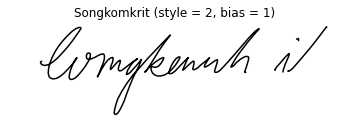

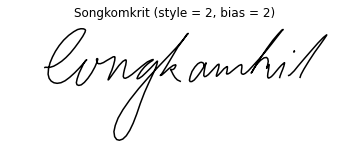

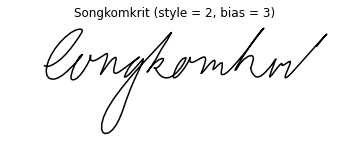

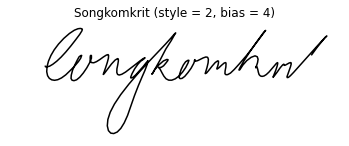

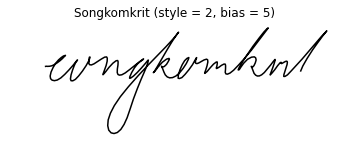

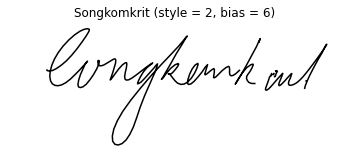

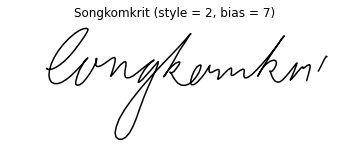

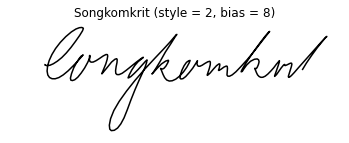

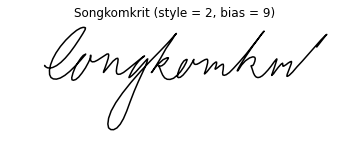

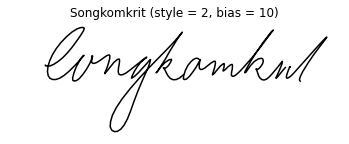

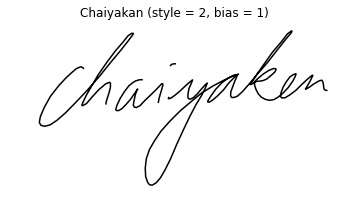

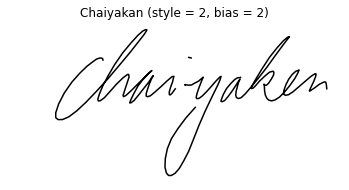

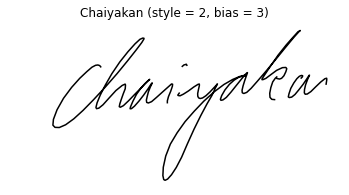

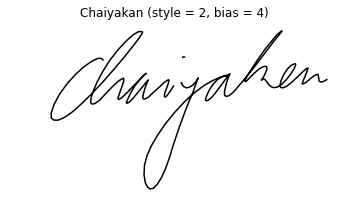

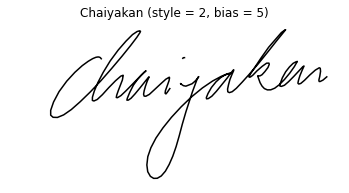

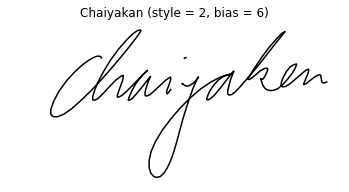

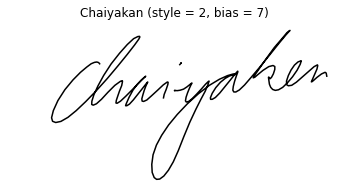

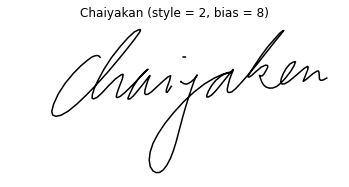

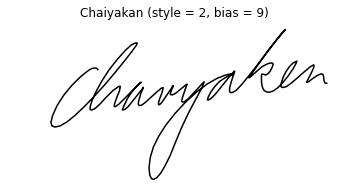

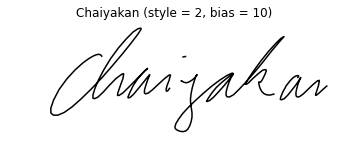

In [8]:
ls_bias = range(1,11)
ls_text = ["Songkomkrit", "Chaiyakan"]

for my_text in ls_text:
  for my_bias in ls_bias:
    my_save = my_text + ".png"
    rnn_generate(my_text, my_style, my_bias, my_model_path, my_save)